In [1]:
from desc import set_device
set_device("gpu")

/home/fcastro/DESC/desc/__init__.py:98: UserWarning: No GPU found, falling back to CPU
  warnings.warn(colored("No GPU found, falling back to CPU", "yellow"))


In [2]:
import numpy as np
import os

from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.constants import mu_0
import sys
import functools
import pickle

import jax
import jax.numpy as jnpå
from jax import jit, jacfwd

from netCDF4 import Dataset
import h5py

from desc.backend import put, fori_loop, jnp, sign

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries

from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.objectives import *
from desc.objectives.objective_funs import _Objective
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison

from desc.plotting import *

from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import SplineProfile, PowerSeriesProfile

from desc.magnetic_fields import ( SplineMagneticField, 
                                  FourierCurrentPotentialField, ToroidalMagneticField,
                                  field_line_integrate)

import desc.examples

from desc.backend import fori_loop, jit, jnp, odeint, sign
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.coils import *

from desc.utils import flatten_list

from desc.utils import Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif

from desc.utils import cross, dot

from desc.optimize import lsqtr, lsq_auglag

from scipy.optimize import NonlinearConstraint 

from desc.magnetic_fields import FourierCurrentPotentialField
#from desc.magnetic_fields._current_potential import run_regcoil

import time

import numpy as np
from numpy.linalg import eig

from scipy.linalg import null_space
from numpy import ndarray

from desc.fns_simp import (#data_eval, 
                           plot_figure,
                           plot_figure2,
                           #plot_figure3,
                           #plot_figure4,
                           plot_xy,
                           surf_int,
                           _compute_magnetic_field_from_Current)

from find_dips import (#f_pair,
                       #   omega_pair,
                       #   comp_loc, 
                       #   shift_grid,
                       #   alt_grid,
                          iso_coords_interp,
                      bn_res,
                      B_dips,
                        B_sticks,
                      K_dips)

DESC version 0.12.3+553.gcb761a802.dirty,using JAX backend, jax version=0.4.35, jaxlib version=0.4.34, dtype=float64
Using device: CPU, with 123.95 GB available memory


In [3]:
# Plasma surfaces
eqname_QA = "/home/fcastro/LMStell/regcoil/rogerio/input.QA_final_output.h5" #vacuum equilibrium
eq_QA = desc.io.load(eqname_QA)[4]

eqname_QH = "/home/fcastro/LMStell/regcoil/rogerio/input.QH_final_output.h5" #vacuum equilibrium
eq_QH = desc.io.load(eqname_QH)[4]

eq = eq_QA    
###
surf_winding = load("iso_coords/surf.h5")

In [12]:
N = 20 # Terms toa pproximate the infinite series

# Numer of dipoles
sMv = np.asarray([5,10,15,20,25,26,27,29,30,])
#sMv = np.asarray([5,10,20,25,])
#sMv = np.asarray([65])
sNv = sMv#np.asarray([20,25,30,35,])
#sNv = sMv

b_chi = []
source_chi = [] # Store the sum of sinks and sources of current
max_I = []

Unequal number of field periods for grid 1 and basis 3.


  warnings.warn(


<class 'numpy.ndarray'>

/home/fcastro/DESC/desc/transform.py:70: UserWarning: 

Unequal number of field periods for grid 1 and basis 3.


  warnings.warn(


<class 'numpy.ndarray'>

/home/fcastro/DESC/desc/transform.py:70: UserWarning: 

Unequal number of field periods for grid 1 and basis 3.


  warnings.warn(


<class 'numpy.ndarray'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

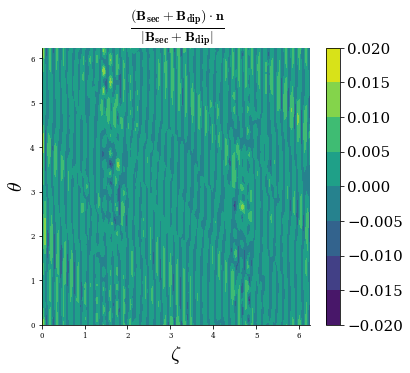

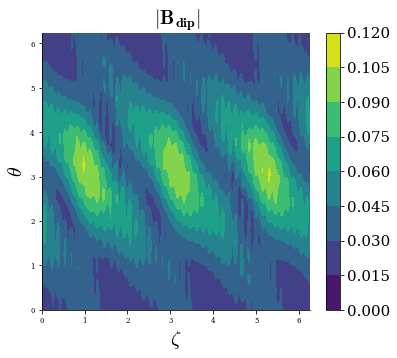

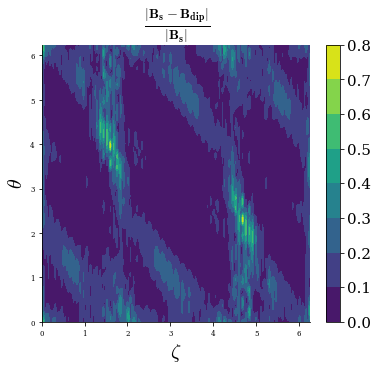

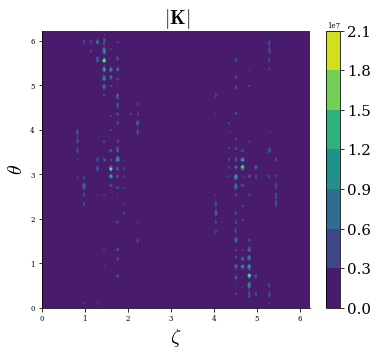

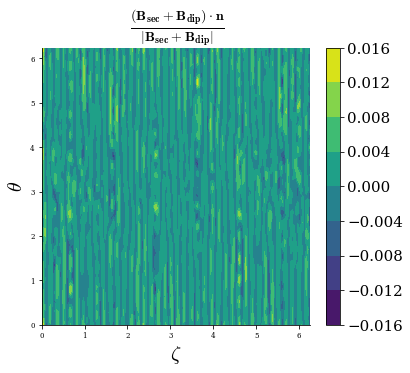

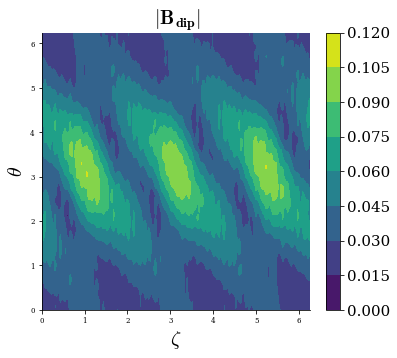

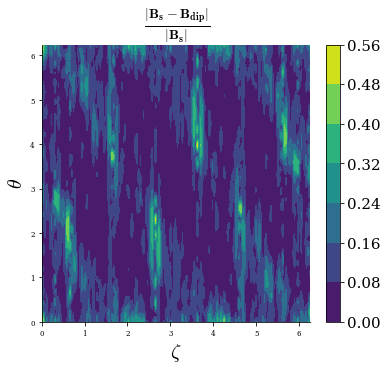

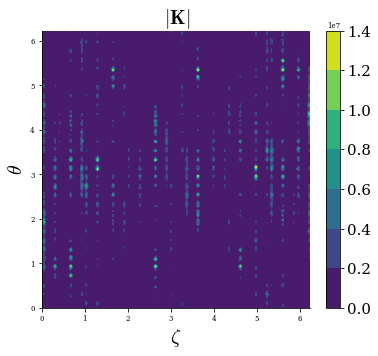

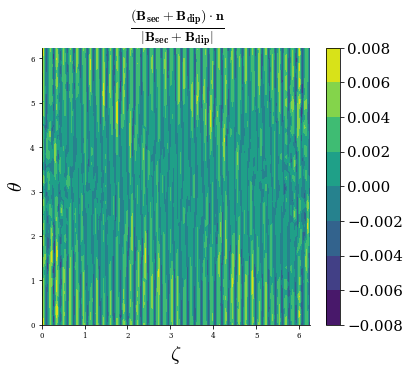

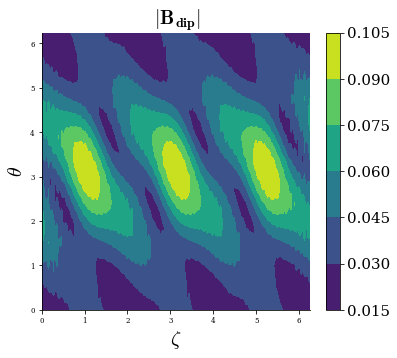

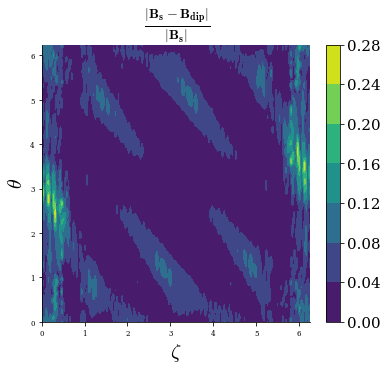

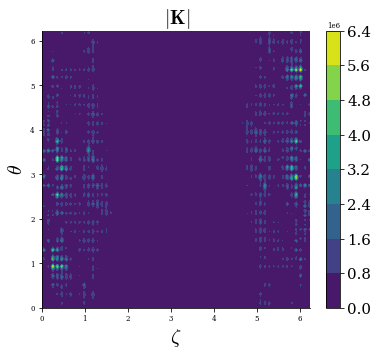

In [13]:
for i in range(0,len(sNv)):

    p_M = sMv[i]
    p_N = sNv[i]

    
    soln = np.load('soln_M_' + str(p_M) + '_N_' + str(p_N) + '.npy')
    error = np.load('error_M_' + str(p_M) + '_N_' + str(p_N) + '.npy')
        
    #G_chi.append(soln[-1])
    b_chi.append(error)
    max_I.append(max(abs(soln)))

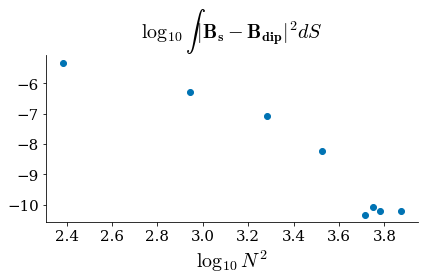

In [14]:
plot_xy(np.log10(b_chi), 
        np.log10(( sMv * 2 + 1 ) * ( sNv * 2 + 1 ) * 2), # grid to plot on
        ''r'$\log_{10} \int | \mathbf{B_s - B_{dip}} | ^2 dS$', # title for the figure
        ''r'$\log_{10} N^2 $', # title of x axis
       )

In [15]:
#plot_xy(np.log10(jnp.asarray(source_chi)), 
#        np.log10(( sMv * 2 + 1 ) * ( sNv * 2 + 1 ) * 2), # grid to plot on
#        ''r'$\log_{10} \Sigma d_i $', # title for the figure
#        ''r'$\log_{10} N^2 $', # title of x axis
#       )

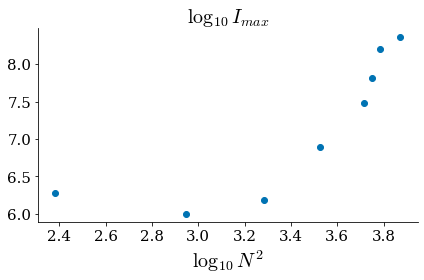

In [16]:
plot_xy(np.log10(jnp.asarray(max_I)), 
        np.log10(( sMv * 2 + 1 ) * ( sNv * 2 + 1 ) * 2), # grid to plot on
        ''r'$\log_{10} I_{max} $', # title for the figure
        ''r'$\log_{10} N^2 $', # title of x axis
       )

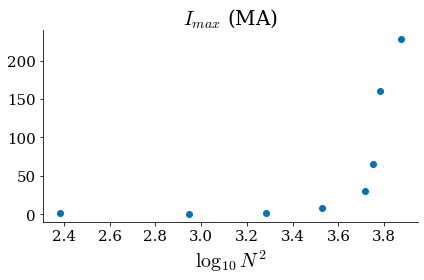

In [17]:
plot_xy(jnp.asarray(max_I)*1e-6, 
        np.log10(( sMv * 2 + 1 ) * ( sNv * 2 + 1 ) * 2), # grid to plot on
        ''r'$ I_{max} $ (MA)', # title for the figure
        ''r'$\log_{10} N^2 $', # title of x axis
       )